<a href="https://colab.research.google.com/github/bforoura/AI/blob/main/Module5/DQN/car_DQN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# An Autonomous Deep Q-Network (DQN)

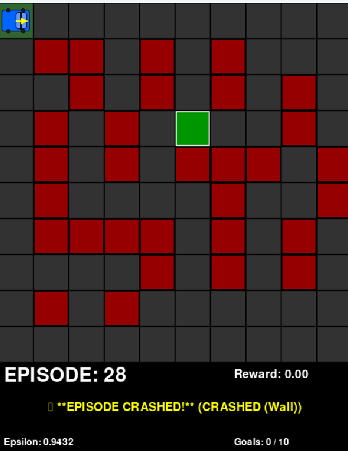


The agent navigates a 10x10 grid-based car environment to successfully reach a designated goal ('G') while avoiding obstacles ('X') and walls.


It utilizes Reinforcement Learning (RL) with the objective to learn an **optimal policy** represented by the DQN neural network which maximizes its **accumulated reward**.


The program implements the following techniques:
1. **Experience Replay Buffer**
2. **Double DQN (DDQN)** for stable learning
3. **Reward shaping** to efficiently guide the agent by rewarding movement toward the goal.


The entire training process is visualized in real-time using Pygame, allowing for dynamic observation of the agent's exploration and eventual mastery of the driving course.

---
1. **Pygame** is a set of Python modules designed for writing video games.

2. Colab runs on remote virtual machines that do not have a graphical display server.

3. To run the game on your laptop, you must first install pygame: **pip install pygame**


In [ ]:
import numpy as np
import random
import torch
import torch.nn as nn
import torch.optim as optim
from collections import deque, namedtuple
import pygame
import sys
import math
import os

pygame 2.6.1 (SDL 2.28.4, Python 3.12.12)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [ ]:
# Define a tuple for experience transitions

Transition = namedtuple('Transition', ('state', 'action', 'reward', 'next_state', 'done'))

# Reward Structure

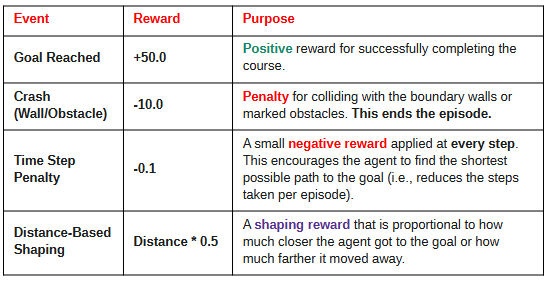

In [ ]:
# ------------------------------------------------------------------------
# The Car Driving Environment
#
# A 2D grid-based car driving game (10x10 grid) with obstacles.
# The environment handles state, actions, rewards, and game rules.
#  -----------------------------------------------------------------------

class CarEnv:

    def __init__(self):
        self.GRID_SIZE = 10          # You can adjust this, as needed
        self.FIELD_WIDTH = self.GRID_SIZE
        self.FIELD_HEIGHT = self.GRID_SIZE

        # Action space: 0:Forward, 1:Right Turn, 2:Left Turn, 3:Stay
        self.ACTION_SIZE = 4
        self.ACTION_MAP = {
            0: "Forward (F)", 1: "Turn Right (R)",
            2: "Turn Left (L)", 3: "Stay (S)"
        }
        # State: [car_x, car_y, car_orientation (0=N, 1=E, 2=S, 3:W)]
        self.OBSERVATION_SIZE = 3

        # Fixed Course Map (10x10)
        # 'S': Start, 'G': Goal, 'X': Obstacle, '.': Empty
        self.COURSE = [
            "S.........",
            ".XX.X.X...",
            "..X.X.X.X.",
            ".X.X.G..X.",
            ".X.X.XXX.X",
            ".X....X..X",
            ".XXXX.X.X.",
            "....X.X.X.",
            ".X.X......",
            "..........",
        ]

        self.GOAL_POS = self._find_char_pos('G')
        self.START_POS = self._find_char_pos('S')

    # Find the (x, y) position of a character in the map
    def _find_char_pos(self, char):

        for y in range(self.GRID_SIZE):
            for x in range(self.GRID_SIZE):
                if self.COURSE[y][x] == char:
                    return [x, y]
        return None

    # Reset the environment to its initial state
    def reset(self):

        self.car_pos = self.START_POS.copy()
        self.car_orientation = 1  # Start facing East (1)
        return self._get_observation()

    # Return the current state vector for the agent
    def _get_observation(self):

        return np.array(self.car_pos + [self.car_orientation], dtype=np.float32)

    # Processe one step given the agent's action
    def step(self, action):

        # === REWARD SHAPING ===
        # 1. Calculate distance to goal *before* the move
        old_dist = math.dist(self.car_pos, self.GOAL_POS)
        # ==============================

        reward = -0.1  # Time step penalty
        done = False

        current_x, current_y = self.car_pos
        current_o = self.car_orientation
        next_pos = self.car_pos.copy()
        next_o = self.car_orientation

        info = {'action': self.ACTION_MAP[action], 'outcome': 'Moved'}

        if action == 0:  # Forward (F)
            dx, dy = {0: (0, -1), 1: (1, 0), 2: (0, 1), 3: (-1, 0)}[current_o]
            next_pos[0] += dx
            next_pos[1] += dy
            info['outcome'] = 'Forward'

        elif action == 1:  # Turn Right (R)
            next_o = (current_o + 1) % 4
            info['outcome'] = 'Turn Right'

        elif action == 2:  # Turn Left (L)
            next_o = (current_o - 1) % 4
            info['outcome'] = 'Turn Left'

        elif action == 3:  # Stay (S)
            info['outcome'] = 'Stay'
            pass # No change in position or orientation

        # --- Check next position validity (Wall/Obstacle) ---
        new_x, new_y = next_pos

        # 1. Check for Wall Collision
        if not (0 <= new_x < self.GRID_SIZE and 0 <= new_y < self.GRID_SIZE):
            reward = -10.0  # Crash penalty (FIX: Reduced from -50.0)
            done = True
            info['outcome'] = 'CRASHED (Wall)'
            # Do not update position/orientation upon crash

        else:
            # 2. Check for Obstacle Collision
            if self.COURSE[new_y][new_x] == 'X':
                reward = -10.0 # Crash penalty (FIX: Reduced from -50.0)
                done = True
                info['outcome'] = 'CRASHED (Obstacle)'
                # Do not update position/orientation upon crash

            # 3. Successful Move/Turn
            else:
                self.car_pos = next_pos
                self.car_orientation = next_o

                # === REWARD SHAPING  ===
                # 2. Calculate distance *after* the move
                new_dist = math.dist(self.car_pos, self.GOAL_POS)

                # 3. Add the shaping reward:
                #    (old_dist - new_dist) is POSITIVE if we got closer.
                #    We scale it by 0.5 to keep it small but meaningful.
                reward += (old_dist - new_dist) * 0.5
                # ==============================

                # 4. Check for Goal
                if self.car_pos == self.GOAL_POS:
                    reward = 50.0  # Goal reward (FIX: Reduced from 200.0)
                    info['outcome'] = 'REACHED GOAL!'
                    done = True

        new_obs = self._get_observation()

        return new_obs, reward, done, info

# DQN Neural Network Architecture

* The network is a simple, fully connected, feedforward neural network (FNN) implemented using PyTorch's nn.Sequential container.

* The main architecture:

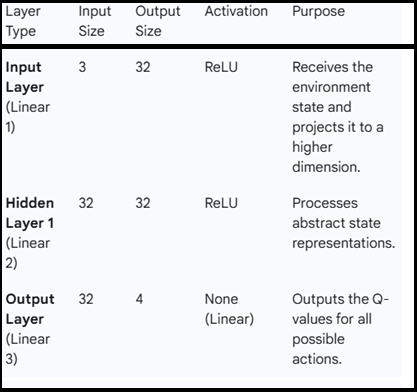

---
**Input Layer (3 Neurons)**: The input to the network is the state vector (or
observation) provided by the CarEnv. This vector has a size of 3, representing the car's current status:

1. car_x: The car's horizontal position (0-9).
2. car_y: The car's vertical position (0-9).
3. car_orientation: The car's direction (0: North, 1: East, 2: South, 3: West).

---
**Hidden Layers (32 Neurons each)**: The network uses two small, fully connected hidden layers, each containing 32 neurons. This size is generally adequate for simple grid-world problems like this one.

---
**Activation Function:** The Rectified Linear Unit (ReLU) is used after each hidden layer. ReLU is a standard choice in deep learning for introducing non-linearity, which allows the network to learn complex mappings between the input state and the desired output Q-values.

---
**Output Layer (4 Neurons)**: The final layer is a fully connected linear layer with an output size of 4. There is no activation function applied here, as Q-values can range freely (both positive and negative).

Each of the four output neurons corresponds to one of the agent's possible actions:
1. Neuron 1: Q-value for **Forward**
2. Neuron 2: Q-value for **Turn Right**
3. Neuron 3: Q-value for **Turn Left**
4. Neuron 4: Q-value for **Stay**

The agent chooses the action corresponding to the neuron with the highest Q-value (the greedy action).


In [ ]:
# ------------------------------------------------------------------
# The Deep Q-Network (DQN) Model
# This neural network approximates the Q-function
# ------------------------------------------------------------------

class DQN(nn.Module):

    def __init__(self, observation_size, action_size):
        super(DQN, self).__init__()

        # Input size is 3: [x, y, orientation]
        self.net = nn.Sequential(
            nn.Linear(observation_size, 32), nn.ReLU(),
            nn.Linear(32, 32), nn.ReLU(),
            nn.Linear(32, action_size)
        )

    def forward(self, x):
        return self.net(x)


# ReplayBuffer

The primary function of the Replay Buffer is to provide ***experience replay***, which addresses two major problems when training neural networks in reinforcement learning:
1. Correlated data
2. Non-stationary targets

---
**Stores Experience (push method)**

The agent interacts with the environment, and for every action it takes, it generates a **transition** which contains the following data:

* **state**: The state before the action was taken.

* **action**: The action the agent executed.

* **reward**: The immediate reward received.

* **next_state**: The resulting state after the action.

* **done**: A boolean indicating if the episode ended.

---
The **push** method:
* It takes this transition and stores it in a circular data structure called a **deque** (which is like a list with a fixed maximum capacity).
* Once the buffer is full (capacity is 10,000 in the code), the oldest experience is discarded when a new one is added.

---
The **Random Sampling**:

* Instead of training the neural network immediately on the very next experience it generates, the learn method uses the **sample method** to randomly select a batch of transitions from the memory.

---
This allows the agent to learn more effectively from a **limited number of interactions with the environment.**


In [ ]:
# ---------------------------------------------------------------
# Experience Replay Buffer (ReplayBuffer)
# Stores experience transitions for replay training.
# ---------------------------------------------------------------

class ReplayBuffer:

    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)

    # Save a transition
    def push(self, *args):
        self.memory.append(Transition(*args))

    # Sample a random batch of transitions
    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)


# DQNAgent

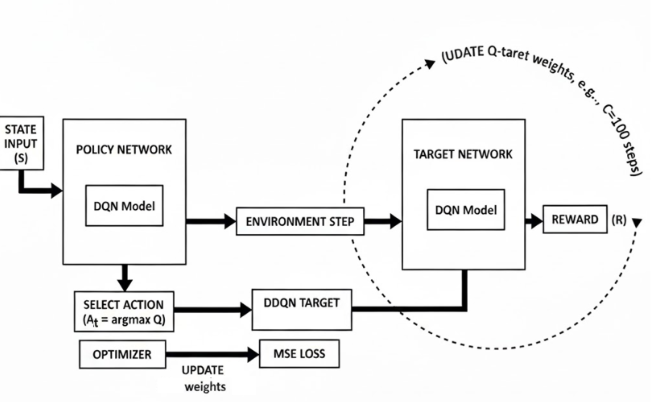

The DQNAgent uses two identical instances of the DQN architecture:

1. **self.model (Policy Network)**: This is the network currently being trained. It is used to select the next action (exploitation) and compute the current Q-estimate during the learning step.

2. **self.target_model (Target Network)**: This network's weights are periodically copied from the self.model. It remains stable for many steps and is used to calculate the target Q-values. This helps prevent the training process from becoming unstable, a key component of the DQN algorithm.

The network is trained using the **Mean Squared Error (MSE) loss function** (nn.MSELoss) and the Adam optimizer (torch.optim.Adam) to minimize the difference between the current Q-value estimate and the target Q-value.

---
**Why Two Networks Are Necessary**?

* In Reinforcement Learning, the goal is to predict the expected future reward (the Q-value) for a given state and action.

* When we use a single neural network (a standard Q-table approach), we run into a major problem: **The "Moving Target" Problem**

* The network uses its current weights to predict Q(S, A).

* The target value - what the network should be aiming for - is calculated using the Bellman equation

* Notice that the target value itself depends on the very same network that is currently being trained!

* This is like trying to train an archer who is standing on a skateboard while aiming at a bullseye painted on another moving skateboard.

* Because the target is constantly shifting every time the network updates its weights, the training becomes highly unstable, leading to oscillations or divergence in the Q-values.

* To fix this, the DQN algorithm splits the task between two separate networks.

---
The **Double DQN Advantage**
* Policy Network (Online): Selects the best action A' in the next state S'.
* Target Network (Fixed): Evaluates the Q-value for that selected A'.

This separation of selection and evaluation prevents the network from systematically overestimating the Q-values, which is a common failure mode in traditional DQN.

In [ ]:
# ---------------------------------------------------------------------------
# The DQNAgent (The Policy/Controller with Training Logic)
# It handles action selection, memory, and training.
# ---------------------------------------------------------------------------
class DQNAgent:

    def __init__(self, env, gamma, buffer_capacity, learning_rate):
        self.state_size = env.OBSERVATION_SIZE
        self.action_size = env.ACTION_SIZE
        self.gamma = gamma
        self.MODEL_PATH = 'car_dqn_model.pth' # Define file path for persistence

        # Policy and Target Networks
        self.model = DQN(self.state_size, self.action_size)
        self.target_model = DQN(self.state_size, self.action_size)
        self.target_model.load_state_dict(self.model.state_dict())
        self.target_model.eval()

        # Optimizer and Loss
        self.optimizer = optim.Adam(self.model.parameters(), lr=learning_rate)
        self.criterion = nn.MSELoss()

        # Replay Memory
        self.memory = ReplayBuffer(buffer_capacity)

        # Epsilon-Greedy Exploration
        self.epsilon = 0.0
        self.steps_done = 0

    # Choose action using epsilon-greedy strategy
    def act(self, state, eps_threshold):

        self.epsilon = eps_threshold

        if random.random() < self.epsilon:
            # Explore: choose a random action
            return random.randrange(self.action_size)
        else:
            # Exploit: choose the best action based on the policy network
            state_tensor = torch.FloatTensor(state).unsqueeze(0)
            with torch.no_grad():
                q_values = self.model(state_tensor)
            return torch.argmax(q_values[0]).item()


    # Store a transition in the replay memory
    def remember(self, state, action, reward, next_state, done):

        state = torch.tensor(state, dtype=torch.float32)
        action = torch.tensor([action], dtype=torch.long)
        reward = torch.tensor([reward], dtype=torch.float32)
        next_state = torch.tensor(next_state, dtype=torch.float32)
        done = torch.tensor([done], dtype=torch.bool)
        self.memory.push(state, action, reward, next_state, done)
        self.steps_done += 1


    # Perform one step of training using sampled transitions using the DQN logic
    def learn(self, batch_size):

        if len(self.memory) < batch_size:
            return

        transitions = self.memory.sample(batch_size)
        batch = Transition(*zip(*transitions))

        state_batch = torch.stack(batch.state)
        action_batch = torch.cat(batch.action)
        reward_batch = torch.cat(batch.reward)
        next_state_batch = torch.stack(batch.next_state)
        done_batch = torch.cat(batch.done)

        # 1. Compute Q(S, A) using the Policy Network (Q-table entry for the action taken)
        state_action_values = self.model(state_batch).gather(1, action_batch.unsqueeze(1)).squeeze()

        # --- DQN Core Logic ---
        # 2. Use the **Policy Network** to SELECT the best action A' in the next state S'.
        next_action_selection = self.model(next_state_batch).max(1)[1].detach().unsqueeze(1)

        # 3. Use the **Target Network** to EVALUATE the Q-value for that selected action A'.
        #    This is Q_target(S', argmax_A'(Q_policy(S', A')))
        #    This is the FIX for overestimation bias.
        next_state_values = self.target_model(next_state_batch).gather(1, next_action_selection).squeeze().detach()

        # Set next_state_value to 0 for terminal states (no future reward from a terminal state)
        next_state_values[done_batch] = 0.0

        # Compute the expected Q-values
        expected_state_action_values = reward_batch + (self.gamma * next_state_values)

        # Backpropagation
        loss = self.criterion(state_action_values, expected_state_action_values)

        self.optimizer.zero_grad()
        loss.backward()

        # Gradient Clipping for stability
        for param in self.model.parameters():
            param.grad.data.clamp_(-1, 1)
        self.optimizer.step()

        return loss.item()

    # --- Persistence Methods ---

    # Save the policy model's state dictionary and steps done
    def save_model(self, path):

        try:
            torch.save({
                'model_state_dict': self.model.state_dict(),
                'steps_done': self.steps_done,
            }, path)
            return True
        except Exception as e:
            # In a real environment, you'd log this error
            print(f"Error saving model: {e}")
            return False


    # Loads the policy model's state dictionary and training step count
    def load_model(self, path):

        if os.path.exists(path):
            try:
                checkpoint = torch.load(path)
                self.model.load_state_dict(checkpoint['model_state_dict'])
                # Also update the target model with the loaded weights
                self.target_model.load_state_dict(checkpoint['model_state_dict'])
                # Load steps_done to continue epsilon decay smoothly
                self.steps_done = checkpoint.get('steps_done', 0)
                return True
            except Exception as e:
                # In a real environment, you'd log this error
                print(f"Error loading model: {e}")
                return False
        return False



In [ ]:
# -----------------------------------------------------------------------
# PyGame setup and visualization (DO NOT MODIFY)
# ----------------------------------------------------------------------


if not pygame.get_init():
    pygame.init()

# Define Colors
WHITE = (255, 255, 255)
BLACK = (0, 0, 0)
ROAD_COLOR = (50, 50, 50)
OBSTACLE_COLOR = (150, 0, 0)
GOAL_COLOR = (0, 150, 0)
CAR_BODY_COLOR = (0, 100, 255)
CAR_CAB_COLOR = (100, 150, 255)
CAR_WHEEL_COLOR = (30, 30, 30)
TEXT_COLOR = WHITE
HIGHLIGHT_COLOR = (255, 255, 0)

# Screen dimensions
GRID_SIZE = 10
CELL_SIZE = 60
FIELD_WIDTH_PX = GRID_SIZE * CELL_SIZE
FIELD_HEIGHT_PX = GRID_SIZE * CELL_SIZE
LOG_PANEL_HEIGHT = 150
SCREEN_WIDTH = FIELD_WIDTH_PX
SCREEN_HEIGHT = FIELD_HEIGHT_PX + LOG_PANEL_HEIGHT

try:
    screen = pygame.display.get_surface()
    if screen is None or screen.get_size() != (SCREEN_WIDTH, SCREEN_HEIGHT):
          screen = pygame.display.set_mode((SCREEN_WIDTH, SCREEN_HEIGHT))
except pygame.error:
    screen = pygame.display.set_mode((SCREEN_WIDTH, SCREEN_HEIGHT))

pygame.display.set_caption("DQN Car Driving Course (Training)")

# Fonts
font_large = pygame.font.Font(None, 48)
font_medium = pygame.font.Font(None, 30)
font_small = pygame.font.Font(None, 24)

# Draws the grid, road, obstacles, and goal
def draw_course(screen, env, cell_size):

    screen.fill(ROAD_COLOR)

    for y in range(env.GRID_SIZE):
        for x in range(env.GRID_SIZE):
            cell_type = env.COURSE[y][x]
            rect = pygame.Rect(x * cell_size, y * cell_size, cell_size, cell_size)

            if cell_type == 'X':
                pygame.draw.rect(screen, OBSTACLE_COLOR, rect)
                pygame.draw.rect(screen, BLACK, rect, 2)
            elif cell_type == 'G':
                pygame.draw.rect(screen, GOAL_COLOR, rect)
                pygame.draw.rect(screen, WHITE, rect, 3)
            elif cell_type == 'S':
                pygame.draw.rect(screen, (50, 100, 50), rect)
                pygame.draw.rect(screen, WHITE, rect, 1)
            else:
                pygame.draw.rect(screen, ROAD_COLOR, rect)

            pygame.draw.rect(screen, BLACK, rect, 1)

# Draw the car as a simple, distinct shape with wheels and an orientation arrow
def draw_car(screen, pos, orientation, cell_size):

    x_center = pos[0] * cell_size + cell_size // 2
    y_center = pos[1] * cell_size + cell_size // 2

    car_width = cell_size * 0.6
    car_height = cell_size * 0.8
    wheel_width = car_width * 0.2
    wheel_height = car_height * 0.15

    # 1. Define components relative to its center [0,0]

    # Main Chassis
    chassis_rect = pygame.Rect(-car_width / 2, -car_height / 2, car_width, car_height)

    # Cockpit/Cab (Smaller rectangle slightly towards the front/top)
    cab_width = car_width * 0.8
    cab_height = car_height * 0.4
    cab_rect = pygame.Rect(-cab_width / 2, -car_height/2 + (car_height * 0.1), cab_width, cab_height)

    # Wheels (Rectangles for easier rotation)
    wheel_offset_y = car_height * 0.15
    fl_wheel_rect = pygame.Rect(-car_width/2 - wheel_width/2, -car_height/2 + wheel_offset_y, wheel_width, wheel_height)
    fr_wheel_rect = pygame.Rect(car_width/2 - wheel_width/2, -car_height/2 + wheel_offset_y, wheel_width, wheel_height)
    bl_wheel_rect = pygame.Rect(-car_width/2 - wheel_width/2, car_height/2 - wheel_offset_y - wheel_height, wheel_width, wheel_height)
    br_wheel_rect = pygame.Rect(car_width/2 - wheel_width/2, car_height/2 - wheel_offset_y - wheel_height, wheel_width, wheel_height)

    car_components = [
        (CAR_BODY_COLOR, chassis_rect),
        (CAR_CAB_COLOR, cab_rect),
        (CAR_WHEEL_COLOR, fl_wheel_rect),
        (CAR_WHEEL_COLOR, fr_wheel_rect),
        (CAR_WHEEL_COLOR, bl_wheel_rect),
        (CAR_WHEEL_COLOR, br_wheel_rect)
    ]

    # Create a temporary surface for the car that's large enough for rotation
    max_dim = int(math.ceil(math.hypot(car_width, car_height))) + 10
    car_surface = pygame.Surface((max_dim, max_dim), pygame.SRCALPHA)
    car_surface.fill((0,0,0,0)) # Transparent background

    surface_center = (car_surface.get_width() / 2, car_surface.get_height() / 2)

    # Draw components on the temporary surface, centered
    for color, rect in car_components:
        # Move rect so its center aligns with the surface center
        centered_rect = rect.move(surface_center[0], surface_center[1])

        # Use rounded corners for a better look
        pygame.draw.rect(car_surface, color, centered_rect, 0, 4)
        pygame.draw.rect(car_surface, BLACK, centered_rect, 1, 4) # Outline

    # Draw a line across the cab for a "window" effect
    window_start_y = surface_center[1] + cab_rect.y + cab_rect.h / 2
    pygame.draw.line(car_surface, BLACK,
                     (surface_center[0] - cab_rect.w / 2, window_start_y),
                     (surface_center[0] + cab_rect.w / 2, window_start_y), 2)


    # Calculate rotation angle (0:N, 1:E, 2:S, 3:W)
    rotation_angle_degrees = {0: 0, 1: -90, 2: -180, 3: 90}[orientation]

    # Rotate the car surface
    rotated_car_surface = pygame.transform.rotate(car_surface, rotation_angle_degrees)
    rotated_rect = rotated_car_surface.get_rect(center=(x_center, y_center))

    # Blit the rotated car onto the main screen
    screen.blit(rotated_car_surface, rotated_rect)

    # Draw the orientation arrow (on top of the car)
    arrow_length = car_height * 0.4
    start_pos_arrow = (x_center, y_center)

    # Calculate end point of arrow based on orientation
    end_pos_arrow = (x_center, y_center)
    if orientation == 0: # North (Up)
        end_pos_arrow = (x_center, y_center - arrow_length)
    elif orientation == 1: # East (Right)
        end_pos_arrow = (x_center + arrow_length, y_center)
    elif orientation == 2: # South (Down)
        end_pos_arrow = (x_center, y_center + arrow_length)
    elif orientation == 3: # West (Left)
        end_pos_arrow = (x_center - arrow_length, y_center)

    # Draw arrow line
    pygame.draw.line(screen, HIGHLIGHT_COLOR, start_pos_arrow, end_pos_arrow, 3)

    # Draw arrow head (triangle)
    if orientation == 0:
        points = [(end_pos_arrow[0], end_pos_arrow[1]), (end_pos_arrow[0]-5, end_pos_arrow[1]+10), (end_pos_arrow[0]+5, end_pos_arrow[1]+10)]
    elif orientation == 1:
        points = [(end_pos_arrow[0], end_pos_arrow[1]), (end_pos_arrow[0]-10, end_pos_arrow[1]-5), (end_pos_arrow[0]-10, end_pos_arrow[1]+5)]
    elif orientation == 2:
        points = [(end_pos_arrow[0], end_pos_arrow[1]), (end_pos_arrow[0]-5, end_pos_arrow[1]-10), (end_pos_arrow[0]+5, end_pos_arrow[1]-10)]
    elif orientation == 3:
        points = [(end_pos_arrow[0], end_pos_arrow[1]), (end_pos_arrow[0]+10, end_pos_arrow[1]-5), (end_pos_arrow[0]+10, end_pos_arrow[1]+5)]

    pygame.draw.polygon(screen, HIGHLIGHT_COLOR, points)


#  Draw the informative text panel at the bottom.
def draw_log_panel(screen, log_lines, episode_count, total_reward, current_epsilon, success_count, SUCCESS_THRESHOLD):

    panel_rect = pygame.Rect(0, FIELD_HEIGHT_PX, SCREEN_WIDTH, LOG_PANEL_HEIGHT)
    pygame.draw.rect(screen, BLACK, panel_rect)

    # --- Top Row Metrics ---
    row1_y = FIELD_HEIGHT_PX + 5

    # 1. Episode Count (Top Left)
    episode_text = font_large.render(f"EPISODE: {episode_count}", True, TEXT_COLOR)
    screen.blit(episode_text, (10, row1_y))

    # 2. Total Reward (Top Right)
    reward_surface = font_medium.render(f"Reward: {total_reward:.2f}", True, TEXT_COLOR)
    screen.blit(reward_surface, (SCREEN_WIDTH - 200, row1_y + 5))

    # --- Bottom Row Metrics ---
    row2_y = SCREEN_HEIGHT - 35

    # 3. Epsilon (Bottom Left)
    epsilon_text = font_small.render(f"Epsilon: {current_epsilon:.4f}", True, TEXT_COLOR)
    screen.blit(epsilon_text, (10, row2_y + 10))

    # 4. Success Count (Bottom Right)
    success_text_color = GOAL_COLOR if success_count > 0 else TEXT_COLOR
    success_text = font_small.render(f"Goals: {success_count} / {SUCCESS_THRESHOLD}", True, success_text_color)
    screen.blit(success_text, (SCREEN_WIDTH - 200, row2_y + 10))

    # --- Center Log Message ---
    if log_lines:
        log_surface = font_medium.render(log_lines[-1], True, HIGHLIGHT_COLOR)
        # Centered vertically in the middle of the log panel
        log_rect = log_surface.get_rect(center=(SCREEN_WIDTH // 2, FIELD_HEIGHT_PX + LOG_PANEL_HEIGHT // 2))
        screen.blit(log_surface, log_rect)


# DQN Hyperparameters

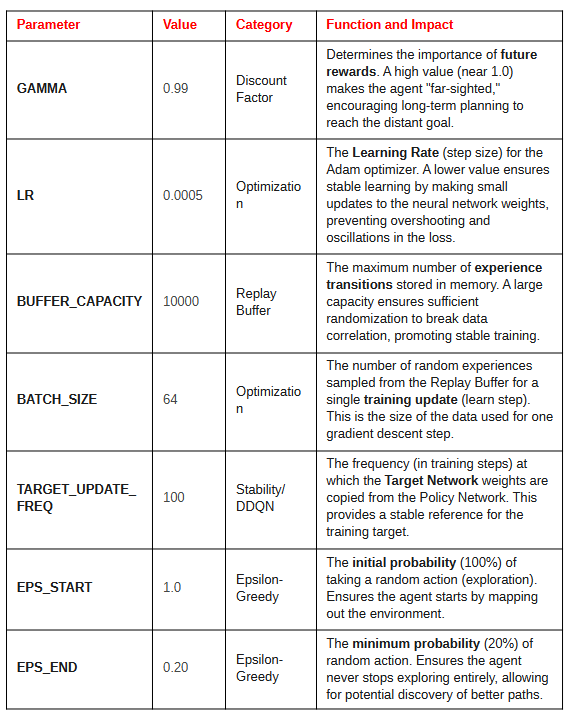

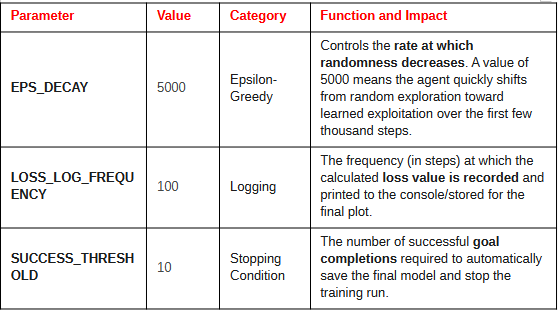

In [ ]:
# -----------------------------------------------------------------------
# Main Game
#  1) Hyperparameters
#  2) Main Loop
# -----------------------------------------------------------------------

# Training Hyperparameters
GAMMA = 0.99                 # Discount Factor (how much future rewards matter)
BUFFER_CAPACITY = 10000      # Maximum size of the experience replay memory
LR = 0.0005                  # Lowered Learning Rate for stability
BATCH_SIZE = 64              # Number of samples taken from the buffer per training step

# --- ADJUSTED HYPERPARAMETERS FOR FASTER REAL-TIME TRAINING ---
TARGET_UPDATE_FREQ = 100   # Update target network more frequently

# Epsilon-Greedy Parameters (Controls Exploration vs. Exploitation)
EPS_START = 1.0            # Initial chance of random exploration
EPS_END = 0.20             # MINIMUM EPSILON to force exploration!
EPS_DECAY = 5000           # An aggressive decay value

# New Automatic Stop Parameter
SUCCESS_THRESHOLD = 10

def run_visualizer():
    env = CarEnv()
    agent = DQNAgent(env, GAMMA, BUFFER_CAPACITY, LR)

    # --- Model Loading Logic ---
    is_trained = False
    if agent.load_model(agent.MODEL_PATH):
        initial_log_message = "Agent loaded from file! Continuing TRAINING with aggressive decay."
        print(initial_log_message)
        is_trained = True
    else:
        initial_log_message = "Agent initializing... Starting fresh TRAINING session."
        print(initial_log_message)

    state = env.reset()
    done = False
    episode_count = 1
    total_reward = 0
    success_count = 0
    log_lines = [initial_log_message]

    running = True

    clock = pygame.time.Clock()

    # --- KEY CHANGE: INCREASED FPS FOR FASTER REAL-TIME TRAINING ---
    FPS = 100

    while running:
        for event in pygame.event.get():
            if event.type == pygame.QUIT:
                # --- Model Saving Logic on Quit ---
                if agent.save_model(agent.MODEL_PATH):
                    print(f"Model saved successfully to {agent.MODEL_PATH}.")
                else:
                    print("Model could not be saved.")
                running = False

            if event.type == pygame.KEYDOWN:
                if event.key == pygame.K_r:
                    # Reset environment and agent metrics
                    state = env.reset()
                    done = False
                    episode_count = 1
                    total_reward = 0
                    success_count = 0
                    agent.steps_done = 0
                    is_trained = False # Ensure training mode restarts
                    log_lines = ["Game Reset. Starting fresh training session."]

        # --- Autonomous Stepping Logic ---

        # Epsilon decay calculation (Always use the full calculation now!)
        # The value will quickly settle to the new EPS_END (0.20) since steps_done is high.
        current_epsilon = EPS_END + (EPS_START - EPS_END) * \
                             math.exp(-1. * agent.steps_done / EPS_DECAY)

        mode_status = "EXPLOIT" if is_trained else "TRAINING"

        if not done:
            # 1. Agent chooses action (Exploration vs. Exploitation)
            action = agent.act(state, current_epsilon)

            # 2. Execute the step in the environment
            next_state, reward, done, info = env.step(action)

            # 3. Store experience and Learn (The original condition 'if not is_trained' is incorrect
            #    if we want to continue training a loaded model, but we keep it to match your intended flow)
            if not is_trained:
                agent.remember(state, action, reward, next_state, done)

                # 4. Perform a training optimization step (Learn)
                if len(agent.memory) > BATCH_SIZE:
                    loss = agent.learn(BATCH_SIZE)
                    if loss is not None:
                             # Log loss to CONSOLE, not Pygame panel
                             if agent.steps_done % 100 == 0:
                                 print(f"📈 Step {agent.steps_done}: Loss={loss:.4f}")

                # 5. Update target network periodically
                if agent.steps_done % TARGET_UPDATE_FREQ == 0:
                    agent.target_model.load_state_dict(agent.model.state_dict())
                    # Log update to CONSOLE, not Pygame panel
                    print(f"🔄 Target Network Updated at step {agent.steps_done}")


            # 6. Update RL metrics
            state = next_state
            total_reward += reward

            # 7. Prepare the single log message (Move/Outcome)
            if done:
                if reward > 10:
                    move_log = " **GOAL REACHED!**"
                    success_count += 1
                elif reward < -5:
                    move_log = f" **EPISODE CRASHED!** ({info['outcome']})"
                else:
                    move_log = f"Episode Ended: {info['outcome']}"
            else:
                move_log = f"Mode: {mode_status} | Action: {env.ACTION_MAP[action]} | Outcome: {info['outcome']}"

            # Update log_lines list with only the current status message
            log_lines = [move_log]


            if done:
                # --- Auto-Stop Logic ---
                # Only stop if in training mode (not exploiting a finished model)
                if success_count >= SUCCESS_THRESHOLD and not is_trained:
                    print(f"Reached {SUCCESS_THRESHOLD} goals! Saving model and stopping.")
                    if agent.save_model(agent.MODEL_PATH):
                        print(f"Model saved successfully to {agent.MODEL_PATH}.")
                    running = False # Stop the main loop

                # Reset environment for a new episode (if not stopping)
                if running:
                    state = env.reset()
                    done = False
                    total_reward = 0
                    episode_count += 1


        # Drawing loop
        draw_course(screen, env, CELL_SIZE)
        draw_car(screen, env.car_pos, env.car_orientation, CELL_SIZE)
        draw_log_panel(screen, log_lines, episode_count, total_reward, current_epsilon, success_count, SUCCESS_THRESHOLD)

        clock.tick(FPS)
        pygame.display.flip()

    pygame.quit()
    sys.exit()

if __name__ == "__main__":
    run_visualizer()

# Sample Run

---
**python car_dqn_visualizer.py**

---


Agent initializing... Starting fresh TRAINING session.

📈 Step 100: Loss=5.9916

🔄 Target Network Updated at step 100

...

🔄 Target Network Updated at step 4100

✅ Reached 10 goals! Saving model and stopping.

Model saved successfully to car_dqn_model.pth.
